In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from apyori import apriori

import datetime

import statsmodels.api as sm

from scipy.stats import spearmanr 

from sklearn.impute import SimpleImputer

from scipy.spatial.distance import cdist 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


import joblib

from math import radians, cos, sin, asin, sqrt
from numpy import mean
from numpy import std

imp_df = pd.read_csv('./dataset_w_weather&rwi.csv')

---------Top 10----------


,Features,Score
0,Date,1.00
21,latitude,1.00
26,Month,1.00
24,weather,1.00
22,longitude,1.00
28,rwi,1.00
7,Kids_Category,0.95
5,Age_Range,0.95
13,Pants_Colour,0.91
27,Year,0.86


---------Bottom 10----------


,Features,Score
19,buyDrinks,0.41
2,Race,0.32
15,Washer_No,0.32
17,Spectacles,0.27
12,shirt_type,0.23
23,Num_of_Baskets,0.18
4,Body_Size,0.14
8,Basket_Size,0.05
14,pants_type,0.05
3,Gender,0.00


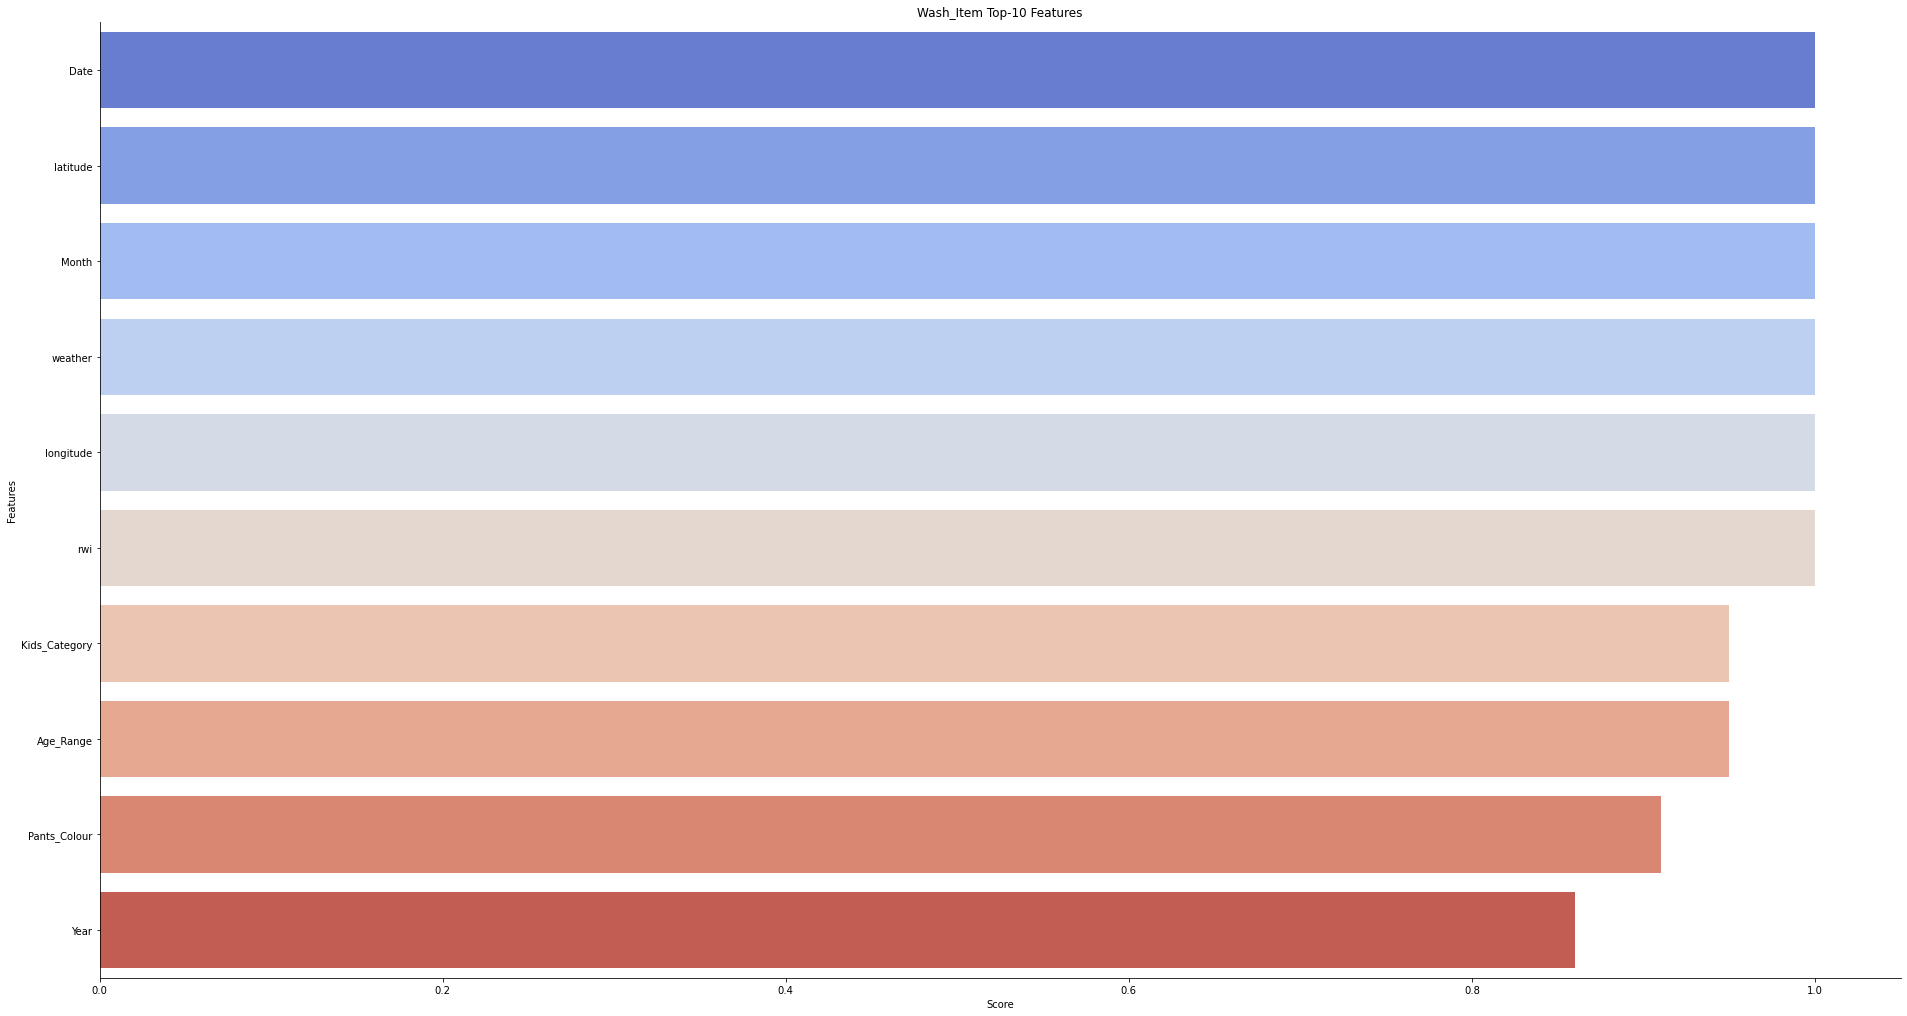

In [5]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))
  
cwi_df = pd.read_csv('./dataset_w_weather&rwi.csv')

fs_df = cwi_df.apply(LabelEncoder().fit_transform)

X = fs_df.drop(['Wash_Item'], axis=1)
y = fs_df['Wash_Item']

rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=1)
feat_selector.fit(X.values, y.values.ravel())

boruta_score = ranking(list(map(float, feat_selector.ranking_)), X.columns, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

print('---------Top 10----------')
display(boruta_score.head(10))

print('---------Bottom 10----------')
display(boruta_score.tail(10))

sns_cwi_plot = sns.catplot(x="Score", y="Features", data = boruta_score[0:10], kind = "bar", height=14, aspect=1.9, palette='coolwarm')
plt.title("Wash_Item Top-10 Features")
sns_cwi_plot.figure.savefig('Wash_Item_Boruta.png')

---------Top 10----------


,Features,Score
21,latitude,1.00
26,Month,1.00
22,longitude,0.96
0,Date,0.93
28,rwi,0.89
5,Age_Range,0.85
24,weather,0.81
18,TimeSpent_minutes,0.78
13,Pants_Colour,0.74
7,Kids_Category,0.70


---------Bottom 10----------


,Features,Score
27,Year,0.33
2,Race,0.30
12,shirt_type,0.26
6,With_Kids,0.22
23,Num_of_Baskets,0.19
4,Body_Size,0.15
8,Basket_Size,0.11
3,Gender,0.07
17,Spectacles,0.04
14,pants_type,0.00


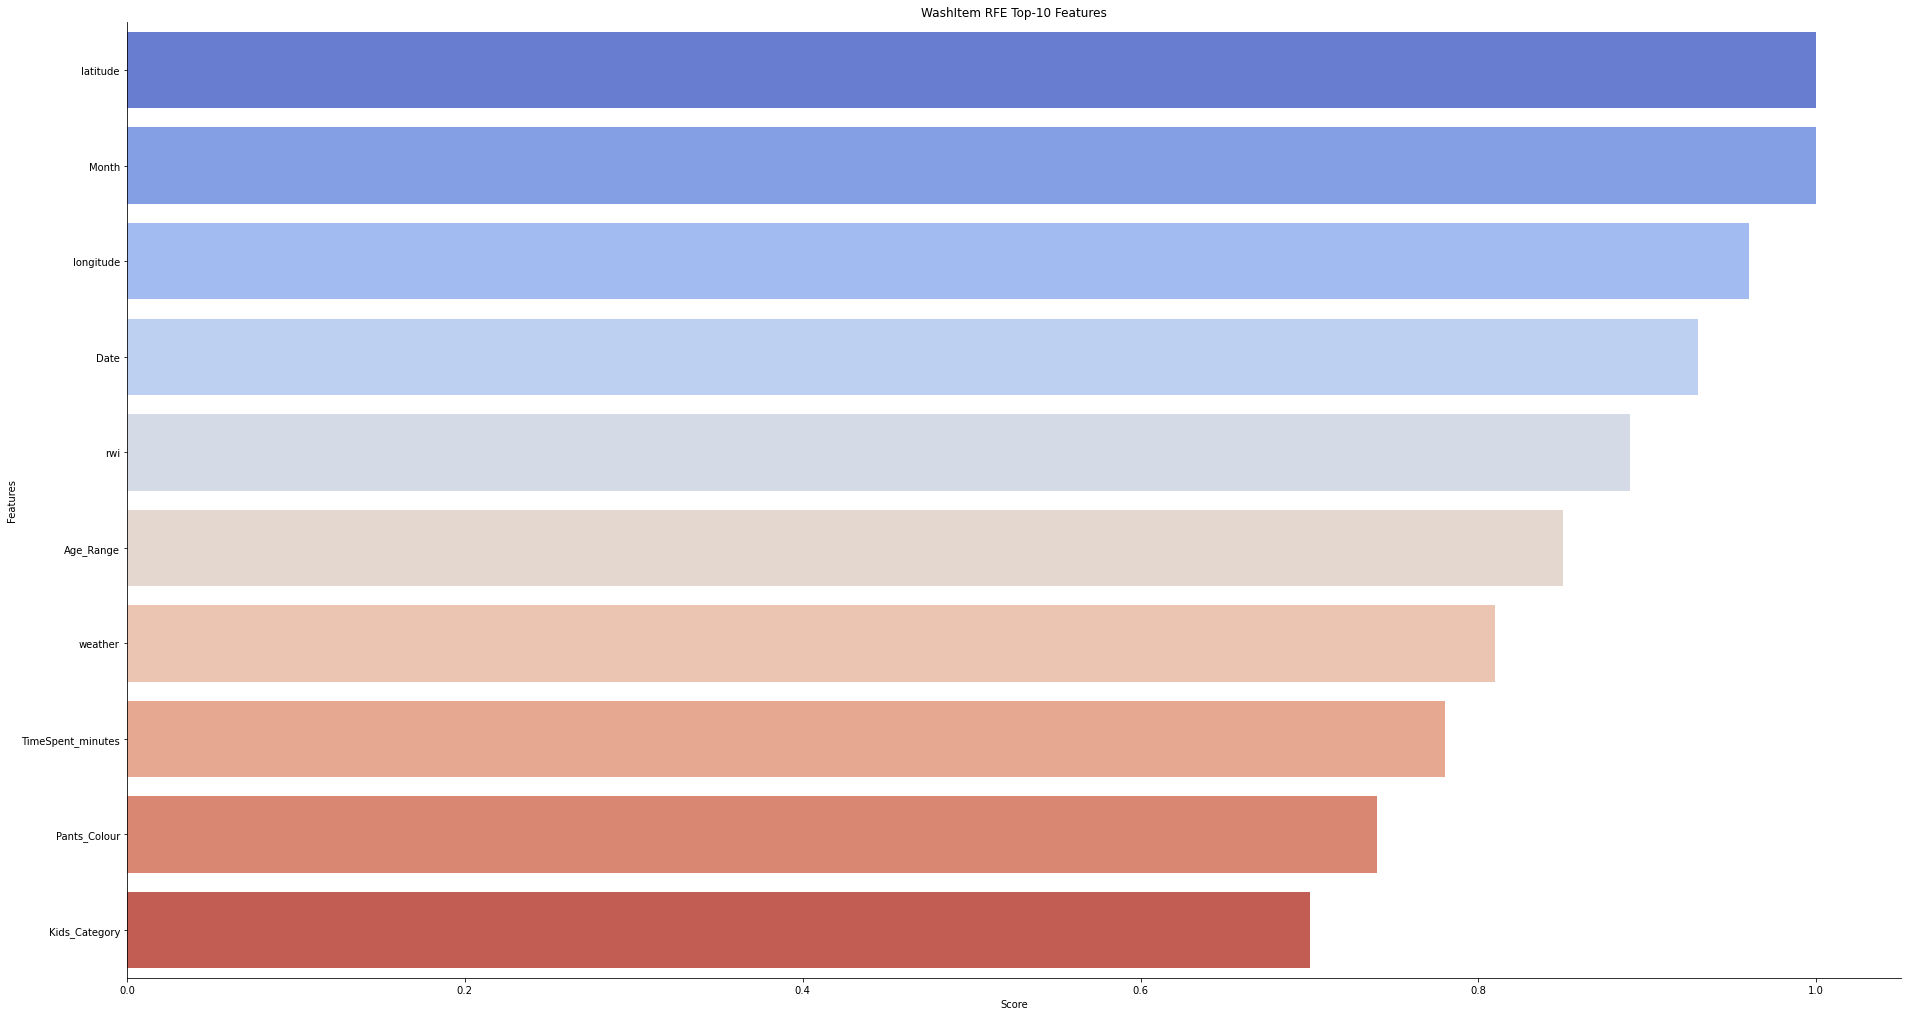

In [6]:
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5, n_estimators=100)
rf.fit(X, y)
rfe = RFECV(rf, min_features_to_select = 1, cv = 3)
rfe.fit(X, y)

rfe_score = ranking(list(map(float, rfe.ranking_)), X.columns, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

print('---------Top 10----------')
display(rfe_score.head(10))

print('---------Bottom 10----------')
display(rfe_score.tail(10))
pd.DataFrame.to_csv(rfe_score.head(10), 'WashItem_RFE_Top10.csv')

sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[0:10], kind = "bar", height=14, aspect=1.9, palette='coolwarm')
plt.title("WashItem RFE Top-10 Features")
sns_rfe_plot.figure.savefig('WashItem_RFE.png')

In [7]:
X = fs_df[["Month", "Date", "latitude" , "weather", "rwi", "Kids_Category", "Age_Range", "Pants_Colour", "TimeSpent_minutes"]]
y = fs_df['Wash_Item']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10) 

## Naive Bayes

In [8]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
filename = 'Wash_Item_NB.sav'
joblib.dump(nb, filename)

print("Accuracy on training set: {:.3f}".format(nb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(nb.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)
print('Mjority classifier Confusion Matrix\n', confusion_majority)
prob_NB = nb.predict_proba(X_test)
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nb.predict(X_test), 
    output_dict=True)
result = pd.DataFrame(sk_report).transpose()
print(result)

Accuracy on training set: 0.556
Accuracy on test set: 0.560
Mjority classifier Confusion Matrix
 [[208 115]
 [206 201]]
              precision    recall  f1-score     support
0              0.502415  0.643963  0.564450  323.000000
1              0.636076  0.493857  0.556017  407.000000
accuracy       0.560274  0.560274  0.560274    0.560274
macro avg      0.569246  0.568910  0.560234  730.000000
weighted avg   0.576936  0.560274  0.559748  730.000000


Class 0 ROC AUC OvR: 0.5869
Class 1 ROC AUC OvR: 0.5869
Average ROC AUC OvR: 0.5869


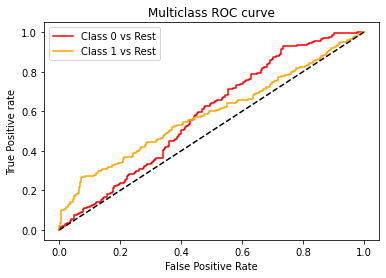

In [9]:
fpr = {}
tpr = {}
thresh = {}
n_class = imp_df['Wash_Item'].nunique()
classes = nb.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_NB[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_NB[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('WASHITEM_NB_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    
# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('WASHITEM_NB_ROC.png')

## Random Forest

In [10]:
rf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_RF = rf.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf.predict(X_test))
print(sk_report)

Accuracy on training set: 0.659
Accuracy on test set: 0.547
Mjority classifier Confusion Matrix
 [[ 65 258]
 [ 73 334]]
              precision    recall  f1-score   support

           0   0.471014  0.201238  0.281996       323
           1   0.564189  0.820639  0.668669       407

    accuracy                       0.546575       730
   macro avg   0.517602  0.510939  0.475332       730
weighted avg   0.522963  0.546575  0.497579       730



Class 0 ROC AUC OvR: 0.5863
Class 1 ROC AUC OvR: 0.5863
Average ROC AUC OvR: 0.5863


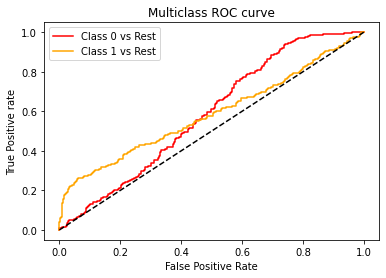

In [11]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Wash_Item'].nunique()
classes = rf.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_RF[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_RF[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETS_RF_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('BASKETS_RF_ROC.png')

# KNN

In [12]:
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(KNN.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(KNN.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

with open('WASHITEM_KNN_ACC.txt', 'w') as f:
    f.write("Accuracy on training set: {:.3f}\n".format(KNN.score(X_train, y_train)))
    f.write("Accuracy on test set: {:.3f}\n".format(KNN.score(X_test, y_test)))
    f.write('Mjority classifier Confusion Matrix\n')
    f.write(str(confusion_majority))
    
prob_KNN = KNN.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=KNN.predict(X_test))
print(sk_report)

Accuracy on training set: 0.761
Accuracy on test set: 0.515
Mjority classifier Confusion Matrix
 [[229  94]
 [260 147]]
              precision    recall  f1-score   support

           0   0.468303  0.708978  0.564039       323
           1   0.609959  0.361179  0.453704       407

    accuracy                       0.515068       730
   macro avg   0.539131  0.535079  0.508872       730
weighted avg   0.547281  0.515068  0.502523       730



Class 0 ROC AUC OvR: 0.5587
Class 1 ROC AUC OvR: 0.5587
Average ROC AUC OvR: 0.5587


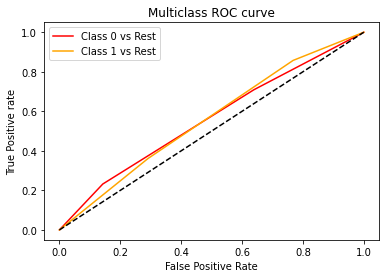

In [13]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Wash_Item'].nunique()
classes = KNN.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_KNN[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_KNN[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETS_KNN_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('WASHITEM_KNN_ROC.png')

## RF TUNING

In [22]:
rf = RandomForestClassifier(random_state=1, n_estimators=500, max_depth=5)
grid_values = {'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]}
grid_rf_acc = GridSearchCV(rf, param_grid = grid_values, scoring = 'accuracy')
grid_rf_acc.fit(X_train, y_train)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_RF = rf.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf.predict(X_test))
print(sk_report)

Accuracy on training set: 0.663
Accuracy on test set: 0.545
Mjority classifier Confusion Matrix
 [[ 65 258]
 [ 74 333]]
              precision    recall  f1-score   support

           0   0.467626  0.201238  0.281385       323
           1   0.563452  0.818182  0.667335       407

    accuracy                       0.545205       730
   macro avg   0.515539  0.509710  0.474360       730
weighted avg   0.521052  0.545205  0.496565       730



Class 0 ROC AUC OvR: 0.5866
Class 1 ROC AUC OvR: 0.5866
Average ROC AUC OvR: 0.5866


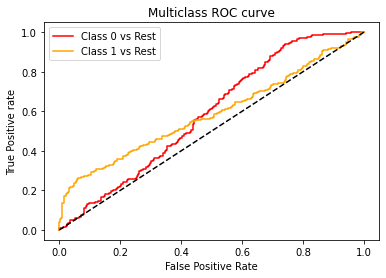

In [23]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Wash_Item'].nunique()
classes = rf.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_RF[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_RF[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('WASH_ITEM_RF_1_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('WASHITEM_RF_1_ROC.png')

In [24]:
rf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

prob_RF = rf.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf.predict(X_test))
print(sk_report)

Accuracy on training set: 0.938
Accuracy on test set: 0.553
Mjority classifier Confusion Matrix
 [[ 98 225]
 [101 306]]
              precision    recall  f1-score   support

           0   0.492462  0.303406  0.375479       323
           1   0.576271  0.751843  0.652452       407

    accuracy                       0.553425       730
   macro avg   0.534367  0.527624  0.513965       730
weighted avg   0.539189  0.553425  0.529901       730



Class 0 ROC AUC OvR: 0.5972
Class 1 ROC AUC OvR: 0.5972
Average ROC AUC OvR: 0.5972


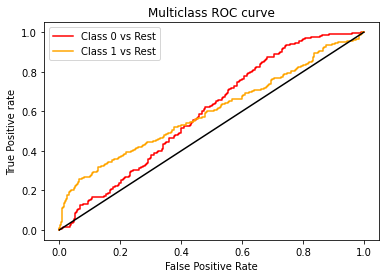

In [26]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Wash_Item'].nunique()
classes = rf.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_RF[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_RF[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('WASH_ITEM_RF_2_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='-')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('WASHITEM_RF_2_ROC.png')

## SMOTE

In [35]:
os = SMOTE(random_state=0)
XSMOTE_train, XSMOTE_test, ySMOTE_train, ySMOTE_test = train_test_split(X, y.values.ravel(), test_size=0.4, random_state=10)
columns = XSMOTE_train.columns
os_data_X, os_data_y = os.fit_resample(XSMOTE_train, ySMOTE_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['Wash_Item'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of 1 in oversampled data",len(os_data_y[os_data_y['Wash_Item']==0]))
print("Number of 2",len(os_data_y[os_data_y['Wash_Item']==1]))
print("Number of 3",len(os_data_y[os_data_y['Wash_Item']==2]))
print("Proportion of 1 data in oversampled data is ",len(os_data_y[os_data_y['Wash_Item']==0])/len(os_data_X))
print("Proportion of 2 data in oversampled data is ",len(os_data_y[os_data_y['Wash_Item']==1])/len(os_data_X))
print("Proportion of 3 data in oversampled data is ",len(os_data_y[os_data_y['Wash_Item']==2])/len(os_data_X))

length of oversampled data is  2530
Number of 1 in oversampled data 1265
Number of 2 1265
Number of 3 0
Proportion of 1 data in oversampled data is  0.5
Proportion of 2 data in oversampled data is  0.5
Proportion of 3 data in oversampled data is  0.0


In [36]:
XSMOTE_train, XSMOTE_test, ySMOTE_train, ySMOTE_test = train_test_split(os_data_X, os_data_y, test_size=0.4, random_state=10)
ySMOTE_test = ySMOTE_test.squeeze()

In [37]:
rf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=100)
rf.fit(XSMOTE_train, ySMOTE_train)
ySMOTE_pred = rf.predict(XSMOTE_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf.score(XSMOTE_train, ySMOTE_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(XSMOTE_test, ySMOTE_test)))

confusion_majority = confusion_matrix(ySMOTE_test, ySMOTE_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

prob_RF = rf.predict_proba(XSMOTE_test)

sk_report = classification_report(
    digits=6,
    y_true=ySMOTE_test, 
    y_pred=rf.predict(XSMOTE_test))
print(sk_report)

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_29658/629169986.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(XSMOTE_train, ySMOTE_train)


Accuracy on training set: 1.000
Accuracy on test set: 0.602
Mjority classifier Confusion Matrix
 [[330 162]
 [241 279]]
              precision    recall  f1-score   support

           0   0.577933  0.670732  0.620884       492
           1   0.632653  0.536538  0.580645       520

    accuracy                       0.601779      1012
   macro avg   0.605293  0.603635  0.600765      1012
weighted avg   0.606050  0.601779  0.600208      1012



Class 0 ROC AUC OvR: 0.6756
Class 1 ROC AUC OvR: 0.6756
Average ROC AUC OvR: 0.6756


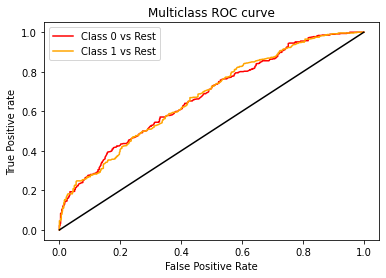

In [39]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Wash_Item'].nunique()
classes = rf.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(ySMOTE_test, prob_RF[:,i], pos_label=i)
    c = classes[i]
    df_aux = XSMOTE_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in ySMOTE_test]
    df_aux['prob'] = prob_RF[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('SMOTE_WASH_ITEM_RF_2_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='-')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('SMOTE_WASHITEM_RF_2_ROC.png')

In [52]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(XSMOTE_train, ySMOTE_train)
y_pred = KNN.predict(XSMOTE_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(KNN.score(XSMOTE_train, ySMOTE_train)))
print("Accuracy on test set: {:.3f}".format(KNN.score(XSMOTE_test, ySMOTE_test)))

confusion_majority = confusion_matrix(ySMOTE_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

with open('WASHITEM_KNN_ACC.txt', 'w') as f:
    f.write("Accuracy on training set: {:.3f}\n".format(KNN.score(XSMOTE_train, ySMOTE_train)))
    f.write("Accuracy on test set: {:.3f}\n".format(KNN.score(XSMOTE_test, ySMOTE_test)))
    f.write('Mjority classifier Confusion Matrix\n')
    f.write(str(confusion_majority))
    
prob_KNN = KNN.predict_proba(XSMOTE_test)

sk_report = classification_report(
    digits=6,
    y_true=ySMOTE_test, 
    y_pred=KNN.predict(XSMOTE_test))
print(sk_report)

Accuracy on training set: 0.786
Accuracy on test set: 0.595
Mjority classifier Confusion Matrix
 [[329 163]
 [247 273]]
              precision    recall  f1-score   support

           0   0.571181  0.668699  0.616105       492
           1   0.626147  0.525000  0.571130       520

    accuracy                       0.594862      1012
   macro avg   0.598664  0.596850  0.593617      1012
weighted avg   0.599424  0.594862  0.592995      1012



/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Class 0 ROC AUC OvR: 0.6194
Class 1 ROC AUC OvR: 0.6194
Average ROC AUC OvR: 0.6194


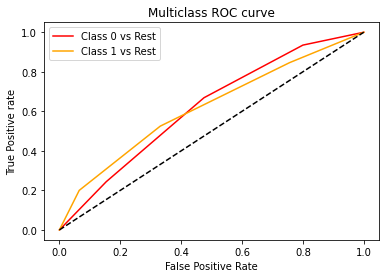

In [54]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Wash_Item'].nunique()
classes = KNN.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(ySMOTE_test, prob_KNN[:,i], pos_label=i)
    c = classes[i]
    df_aux = XSMOTE_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in ySMOTE_test]
    df_aux['prob'] = prob_KNN[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETS_KNN_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('WASHITEM_KNN_ROC.png')

## Ensemble

In [18]:

estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = KNeighborsClassifier(n_neighbors=3)
estimators.append(('knn', model2))
model3 = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=10)

estimators.append(('rf', model3))
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("Accuracy on training set: {:.3f}".format(ensemble.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(ensemble.score(X_test, y_test)))
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
prob_ESB = rf.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=ensemble.predict(X_test))
print(sk_report)

/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on training set: 0.857
Accuracy on test set: 0.564
Accuracy Score : 0.5643835616438356
Precision Score : 0.5787610619469027
Recall Score : 0.8034398034398035
F1 Score : 0.6728395061728395
Mjority classifier Confusion Matrix
 [[ 85 238]
 [ 80 327]]
              precision    recall  f1-score   support

           0   0.515152  0.263158  0.348361       323
           1   0.578761  0.803440  0.672840       407

    accuracy                       0.564384       730
   macro avg   0.546956  0.533299  0.510600       730
weighted avg   0.550616  0.564384  0.529269       730



/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

>lr 0.568 (0.022)
>knn 0.554 (0.025)
>cart 0.541 (0.028)
>svm 0.573 (0.001)
>bayes 0.546 (0.028)


/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

>stacking 0.547 (0.025)


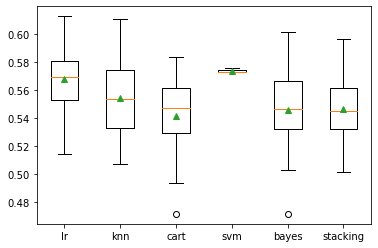

In [19]:
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))
level1 = LogisticRegression()
stacked_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

models = dict()
models['lr'] = LogisticRegression()
models['knn'] = KNeighborsClassifier()
models['cart'] = DecisionTreeClassifier()
models['svm'] = SVC()
models['bayes'] = GaussianNB()
models['stacking'] = stacked_model

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# SVM

In [20]:
# svm
svc = SVC( probability=True, random_state=1, kernel='rbf', C=10, gamma=0.1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test, y_test)))
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
prob_svc = svc.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=svc.predict(X_test))
print(sk_report)

Accuracy on training set: 1.000
Accuracy on test set: 0.558
Accuracy Score : 0.5575342465753425
Precision Score : 0.5575342465753425
Recall Score : 1.0
F1 Score : 0.7159190853122251
Mjority classifier Confusion Matrix
 [[  0 323]
 [  0 407]]
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000       323
           1   0.557534  1.000000  0.715919       407

    accuracy                       0.557534       730
   macro avg   0.278767  0.500000  0.357960       730
weighted avg   0.310844  0.557534  0.399149       730



/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 ROC AUC OvR: 0.5100
Class 1 ROC AUC OvR: 0.5063
Average ROC AUC OvR: 0.5082


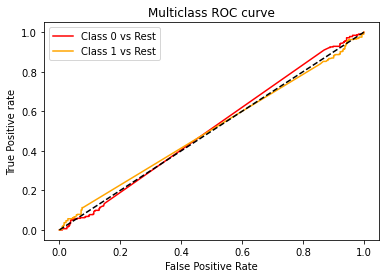

In [21]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Wash_Item'].nunique()
classes = svc.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_svc[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_svc[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('WASH_ITEM_SVC_1_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('WASHITEM_SVC_1_ROC.png')